In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import scipy.io as sio
import cmocean as cm
import geopandas as gpd
import pandas as pd

In [2]:
xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

In [3]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [4]:
project = 'fvcom'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = True
latent_dim = 30

In [6]:
states = gpd.read_file(f'{project_root}/data/massachusetts/s_08mr23.shp')
mass = states[states['NAME']=='Massachusetts']

In [7]:
grid_x = np.load(f'{project_root}/data/{project}/grid_x.npy')
grid_y = np.load(f'{project_root}/data/{project}/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

u1 = np.load(f'{project_root}/data/{project}/u_interp.npy') 
u2 = np.load(f'{project_root}/data/{project}/v_interp.npy')
t = np.load(f'{project_root}/data/{project}/t.npy')
nt, n1, n2 = u1.shape
mask = ~np.isnan(u1[0,:,:])

X, scaler = transform_data_for_AE(u1,u2)
data = transform_data_for_AE_inverse(X, scaler)
data[:, :, ~mask] = np.nan 

In [8]:
reference_date = pd.Timestamp("2005-01-01")
datetimes = [reference_date + pd.to_timedelta(days - 732313.0, unit='D') for days in t]
datetimes_np = np.array(datetimes, dtype='datetime64[ns]')

In [9]:
# === Consistent train/val/test split ===
n_train = int(0.5 * nt)
n_val = int(0.2 * nt)
n_test = nt - n_train - n_val

train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + n_val)
test_idx = np.arange(n_train + n_val, nt)


X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (7737, 2, 64, 64), Val shape: (3095, 2, 64, 64), Test shape: (4643, 2, 64, 64)


In [10]:
mlp_input_dim = X[:, :, mask].reshape(X.shape[0], -1).shape[1]

In [11]:
pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim, mask=mask)
mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
mlp.to(device)
cnn = CNN_AE(latent_dim=latent_dim)
cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
cnn.to(device);

In [12]:
# Compute test error for each model
mask_broadcast = mask[None, :, :]  # shape (1, n1, n2)

# 1. PCA only (reconstruction from PCA)
X_pca_recon, Z_pca = pca.forward(X)
X_pca_recon = transform_data_for_AE_inverse(X_pca_recon, scaler)

# 2. MLP Autoencoder
mlp.eval()
with torch.no_grad():
    X_mlp_recon, Z_mlp = mlp(torch.tensor(X, dtype=torch.float32, device=device))
    X_mlp_recon = X_mlp_recon.cpu().numpy()
    X_mlp_recon = transform_data_for_AE_inverse(X_mlp_recon, scaler)

# 3. CNN Autoencoder (batched to avoid CUDA OOM)
cnn.eval()
batch_size = 16  
n_samples = X.shape[0]
X_cnn_recon = []
with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32, device=device)
        recon_batch, _ = cnn(batch_tensor)
        X_cnn_recon.append(recon_batch.cpu().numpy())
X_cnn_recon = np.concatenate(X_cnn_recon, axis=0)
X_cnn_recon = transform_data_for_AE_inverse(X_cnn_recon, scaler)
X_cnn_recon[:,:, ~mask] = np.nan  

/home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [13]:
def compute_rmse(true, pred):    
    return np.sqrt(np.nanmean((true - pred) ** 2))

fields = {
    'Truth': (data[:, 0], data[:, 1]),
    'PCA': (X_pca_recon[:, 0], X_pca_recon[:, 1]),
    'MLP': (X_mlp_recon[:, 0], X_mlp_recon[:, 1]),
    'CNN': (X_cnn_recon[:, 0], X_cnn_recon[:, 1]),
}

u_true, v_true = fields['Truth']
omega_true = vort_FVCOM(u_true, v_true, grid_x_m, grid_y_m)  
psi_true = streamfunction_FVCOM(omega_true, grid_x_m, grid_y_m)  

omega_true = omega_true * 1e5  # Convert to 10^-5 s^-1

omega_true[..., ~mask] = np.nan
psi_true[..., ~mask] = np.nan

omega_fields = {'Truth': omega_true,}
psi_fields = {'Truth': psi_true,}

results = {}

for key, (u, v) in fields.items():
    u_pred, v_pred = u, v

    omega_field = vort_FVCOM(u, v, grid_x_m, grid_y_m)
    psi_field = streamfunction_FVCOM(omega_field, grid_x_m, grid_y_m)

    omega_field = omega_field * 1e5  # Convert to 10^-5 s^-1

    omega_field[..., ~mask] = np.nan
    psi_field[..., ~mask] = np.nan

    omega_fields[key] = omega_field
    psi_fields[key] = psi_field

    # Split indices
    splits = {
        'total': np.arange(u_true.shape[0]),
        'train': train_idx,
        'val': val_idx,
        'test': test_idx
    }

    # Compute RMSE for each split
    rmse = {}
    for split_name, idx in splits.items():
        rmse_u = compute_rmse(u_true[idx], u_pred[idx])
        rmse_v = compute_rmse(v_true[idx], v_pred[idx])
        rmse_omega = compute_rmse(omega_true[idx], omega_field[idx])
        rmse_psi = compute_rmse(psi_true[idx], psi_field[idx])
        rmse[split_name] = {
            'u': rmse_u,
            'v': rmse_v,
            'omega': rmse_omega,
            'psi': rmse_psi
        }

    results[key] = {'rmse': rmse}
    

In [14]:
# Print results
for key in ['PCA', 'MLP', 'CNN']:
    print(f"{key}:")
    for split_name, rmse in results[key]['rmse'].items():
        print(f"  {split_name}: u={rmse['u']:.4f}, v={rmse['v']:.4f}, omega={rmse['omega']:.4f}, psi={rmse['psi']:.5f}")

PCA:
  total: u=0.0590, v=0.0603, omega=1.8265, psi=278.10170
  train: u=0.0580, v=0.0594, omega=1.8059, psi=276.37870
  val: u=0.0600, v=0.0616, omega=1.8479, psi=291.86210
  test: u=0.0599, v=0.0610, omega=1.8461, psi=271.48576
MLP:
  total: u=0.0535, v=0.0540, omega=1.6584, psi=252.67288
  train: u=0.0500, v=0.0506, omega=1.5767, psi=232.44394
  val: u=0.0569, v=0.0577, omega=1.7416, psi=284.52739
  test: u=0.0566, v=0.0569, omega=1.7329, psi=262.27751
CNN:
  total: u=0.0543, v=0.0551, omega=1.8050, psi=229.77924
  train: u=0.0495, v=0.0505, omega=1.7144, psi=194.90813
  val: u=0.0589, v=0.0598, omega=1.8923, psi=270.69867
  test: u=0.0585, v=0.0590, omega=1.8908, psi=252.63623


In [15]:

def pattern_corr(a, b):
    """
    Compute centered pattern correlation between two datasets with shape (nt, ...),
    handling NaNs per snapshot.

    Parameters
    ----------
    a, b : np.ndarray
        Arrays of shape (nt, spatial_dims...), e.g., (time, lat, lon).

    Returns
    -------
    corr : np.ndarray
        Pattern correlation for each snapshot (shape: nt).
    """
    nt = a.shape[0]
    corr = np.empty(nt)
    
    for i in range(nt):
        a_flat = a[i].ravel()
        b_flat = b[i].ravel()
        
        # Mask NaNs
        mask = ~np.isnan(a_flat) & ~np.isnan(b_flat)
        a_masked = a_flat[mask]
        b_masked = b_flat[mask]
        
        # Skip snapshot if no valid points
        if len(a_masked) == 0:
            corr[i] = np.nan
            continue
        
        # Centered anomalies
        a_centered = a_masked - a_masked.mean()
        b_centered = b_masked - b_masked.mean()
        
        # Pattern correlation
        num = np.sum(a_centered * b_centered)
        denom = np.sqrt(np.sum(a_centered**2) * np.sum(b_centered**2))
        corr[i] = num / denom
    
    return corr


# Example usage:
corr_pca_omega = pattern_corr(omega_true[test_idx], omega_fields['PCA'][test_idx])
corr_mlp_omega = pattern_corr(omega_true[test_idx], omega_fields['MLP'][test_idx])
corr_cnn_omega = pattern_corr(omega_true[test_idx], omega_fields['CNN'][test_idx])

print("Pattern correlation (PCA, test):", np.mean(corr_pca_omega))
print("Pattern correlation (MLP, test):", np.mean(corr_mlp_omega))
print("Pattern correlation (CNN, test):", np.mean(corr_cnn_omega))

corr_pca_psi = pattern_corr(psi_true[test_idx], psi_fields['PCA'][test_idx])
corr_mlp_psi = pattern_corr(psi_true[test_idx], psi_fields['MLP'][test_idx])
corr_cnn_psi = pattern_corr(psi_true[test_idx], psi_fields['CNN'][test_idx])

print("Pattern correlation (PCA, test):", np.mean(corr_pca_psi))
print("Pattern correlation (MLP, test):", np.mean(corr_mlp_psi))
print("Pattern correlation (CNN, test):", np.mean(corr_cnn_psi))


Pattern correlation (PCA, test): 0.8036835564130443
Pattern correlation (MLP, test): 0.8277109807869866
Pattern correlation (CNN, test): 0.7903024805988889
Pattern correlation (PCA, test): 0.9348253596459278
Pattern correlation (MLP, test): 0.9400103235126198
Pattern correlation (CNN, test): 0.9421464638134305


In [16]:
# Compute average error between prediction and ground truth for u and v over the test set
average_rmse = np.nanmean(np.abs(X_test - X_cnn_recon[test_idx]))
rmse_per_timestep = np.nanmean(np.abs(X[test_idx] - X_cnn_recon[test_idx]), axis=(1,2,3))

indices_avg_error = np.argsort(np.abs(rmse_per_timestep - average_rmse))[:15]
print("Indices with average error close to mean error (CNN):")
for idx in indices_avg_error:
    test_sample_idx = test_idx[idx]
    rmse_value = rmse_per_timestep[idx]
    print(f"Index: {test_sample_idx}, RMSE: {rmse_value:.4f}")

Indices with average error close to mean error (CNN):
Index: 15334, RMSE: 0.6033
Index: 14211, RMSE: 0.6033
Index: 14449, RMSE: 0.6034
Index: 14437, RMSE: 0.6034
Index: 14883, RMSE: 0.6035
Index: 12093, RMSE: 0.6031
Index: 13072, RMSE: 0.6035
Index: 11260, RMSE: 0.6035
Index: 13833, RMSE: 0.6030
Index: 11137, RMSE: 0.6036
Index: 11129, RMSE: 0.6029
Index: 13292, RMSE: 0.6037
Index: 14843, RMSE: 0.6037
Index: 12218, RMSE: 0.6037
Index: 14139, RMSE: 0.6037


06-10-11


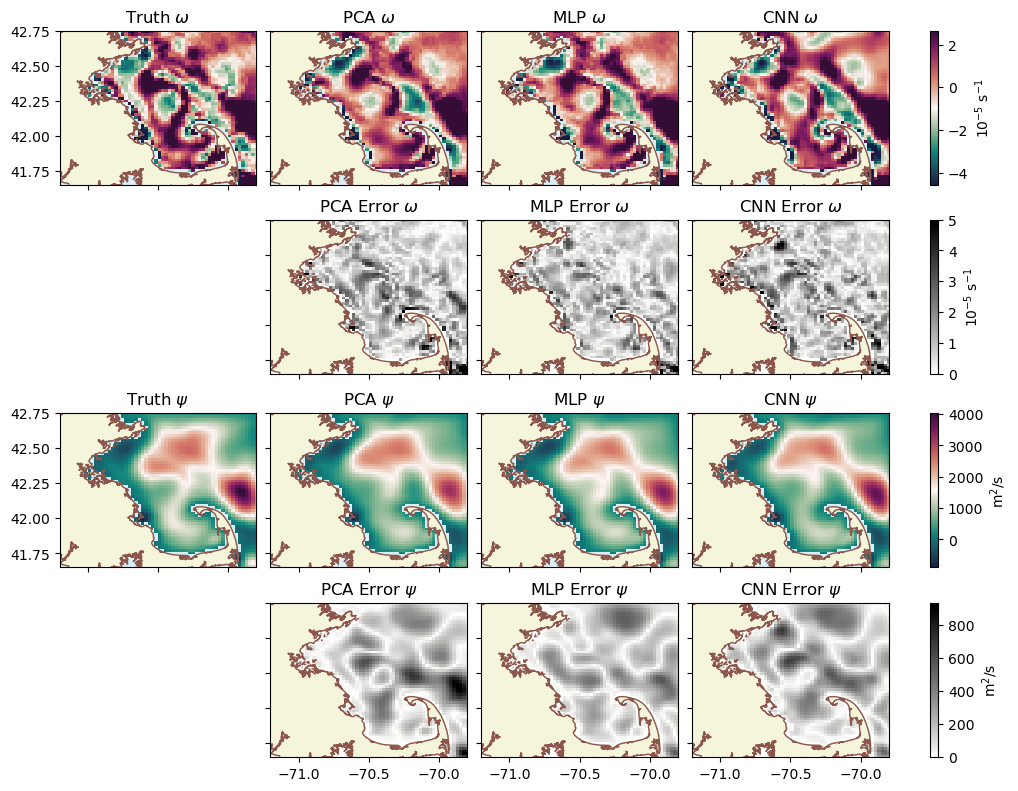

In [24]:
# Choose a timestep to visualize
timestep  = 11129

date_print = f'{str(datetimes_np[timestep][0])[:10]}'.replace('-', '/').split('/')[1] + '-' + str(datetimes_np[timestep][0])[:10].replace('-', '/').split('/')[2] + '-' + str(datetimes_np[timestep][0])[:10].replace('-', '/').split('/')[0][2:]
print(date_print)

def plot_contours(data_dict, title, grid_x, grid_y, row_idx=0, cmap=cm.cm.curl):
    arrs = [np.array(arr[timestep]) for arr in data_dict.values()]
    if title == '$\omega$':
        vmin = 0.1*min(np.nanmin(arr) for arr in arrs)
        vmax = 0.1*max(np.nanmax(arr) for arr in arrs)
    elif title == '$\psi$':
        vmin = min(np.nanmin(arr) for arr in arrs)
        vmax = max(np.nanmax(arr) for arr in arrs)
    for i, (key, arr) in enumerate(data_dict.items()):
        ax = axs[row_idx, i]
        if title == '$\omega$':
            ax.set_facecolor(np.array([218, 240, 247]) / 255)
            cf = ax.pcolormesh(grid_x, grid_y, np.array(arr[timestep]), vmin=vmin, vmax=vmax, cmap=cmap)
        elif title == '$\psi$':
            ax.set_facecolor(np.array([218, 240, 247]) / 255)
            # cf = ax.contour(grid_x, grid_y, np.array(arr[timestep]), levels=10, vmin=vmin, vmax=vmax, cmap=cmap)
            cf = ax.pcolormesh(grid_x, grid_y, np.array(arr[timestep]), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(key + ' ' + title)
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_aspect('equal')
    # Shared colorbar for the row
    fig.colorbar(cf, ax=axs[row_idx, :], orientation='vertical',
                 label=('m$^2$/s' if title == '$\psi$' else '10$^{-5}$ s$^{-1}$'))

def plot_error_contours(true_dict, pred_dict, title, grid_x, grid_y, row_idx=0, cmap=cm.cm.gray_r):
    true_arr = np.array(true_dict['Truth'][timestep])
    vmin = 0
    if title == '$\omega$ error':
        vmax = 5
    elif title == '$\psi$ error':
        arrs = [np.array(pred_dict[key][timestep]) for key in pred_dict.keys()]
        vmax = max(np.nanmax(np.abs(arr - true_arr)) for arr in arrs)

    for i, key in enumerate(pred_dict.keys()):
        ax = axs[row_idx, i+1]
        pred_arr = np.array(pred_dict[key][timestep])
        err = np.abs(pred_arr - true_arr)
        if title == '$\omega$ error':
            cf = ax.pcolormesh(grid_x, grid_y, err, cmap=cmap, vmin=vmin, vmax=vmax)
            variable = '$\omega$'
        elif title == '$\psi$ error':
            cf = ax.pcolormesh(grid_x, grid_y, err, cmap=cmap, vmin=vmin, vmax=vmax)
            variable = '$\psi$'
        ax.set_title(key + ' Error ' + variable)
        mass.plot(ax=ax, color='beige', edgecolor='tab:brown')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_aspect('equal')
    # Shared colorbar for the error row (skip axs[1,0])
    fig.colorbar(cf, ax=axs[row_idx, :], orientation='vertical',
                 label=('m$^2$/s' if title == '$\psi$ error' else '10$^{-5}$ s$^{-1}$'))

fig, axs = plt.subplots(4, 4, figsize=(10, 7.8), sharex=True, sharey=True, constrained_layout=True)
plot_contours(omega_fields, '$\omega$', grid_x, grid_y, row_idx=0)
step = 4
xq, yq, mask_q = grid_x[::step, ::step], grid_y[::step, ::step], mask[::step, ::step]
# for i, (key, (u, v)) in enumerate(fields.items()):
#     ax = axs[0, i]
#     ax.quiver(xq[mask_q], yq[mask_q], u[timestep, ::step, ::step][mask_q], v[timestep, ::step, ::step][mask_q], scale=7, scale_units='xy')
#     ax.set_title(key)
axs[1, 0].axis('off')
plot_error_contours(omega_fields, {k: omega_fields[k] for k in ['PCA', 'MLP', 'CNN']}, '$\omega$ error', grid_x, grid_y, row_idx=1)
# plt.savefig(f'{project_root}/figures/{project}/rom/vorticity_comparison_latent_dim_{latent_dim}_idx_{timestep}.png', dpi=300, bbox_inches='tight')

# fig, axs = plt.subplots(2, 4, figsize=(11, 4), sharex=True, sharey=True)
plot_contours(psi_fields, '$\psi$', grid_x, grid_y, row_idx=2)
axs[3, 0].axis('off')
plot_error_contours(psi_fields, {k: psi_fields[k] for k in ['PCA', 'MLP', 'CNN']}, '$\psi$ error', grid_x, grid_y, row_idx=3)
# plt.savefig(f'{project_root}/figures/{project}/rom/streamfunction_comparison_latent_dim_{latent_dim}_idx_{timestep}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{project_root}/figures/{project}/rom/vorticity_streamfunction_comparison_latent_dim_{latent_dim}_idx_{date_print}.png', dpi=300, bbox_inches='tight')